Gaelle_Genvrin_P5_3_bis_112024 "clustering non supervisé"

**INTRODUCTION**<br>
Modélisation thématique : LDA et NMF<br>
**Objectif**<br>
Dans ce notebook, nous explorons des méthodes de modélisation thématique non supervisée pour identifier automatiquement les sujets dominants dans un corpus de questions issues de Stack Overflow.<br>

L’objectif est de générer des groupes de mots-clés cohérents représentant les grands thèmes abordés, sans avoir besoin d’annotations manuelles.<br>

**Méthodes utilisées**<br>
Deux techniques majeures de topic modeling sont comparées :<br>

**LDA** (Latent Dirichlet Allocation) : une approche probabiliste où chaque document est modélisé comme une combinaison de thèmes, et chaque thème comme une distribution de mots.<br>

**NMF** (Non-Negative Matrix Factorization) : une méthode de factorisation matricielle qui décompose la matrice TF-IDF pour faire émerger des composantes thématiques, tout en imposant une contrainte de non-négativité.

**Évaluation des résultats**<br>
Les modèles ont été évalués selon deux niveaux d’analyse :<br>

Évaluation interne pour déterminer la qualité et la cohérence des topics :<br>

<u>Score de perplexité </u>(LDA uniquement) : mesure la capacité du modèle à prédire de nouvelles données.<br>
<u>Score de cohérence </u>: évalue la similarité sémantique entre les mots d’un même topic.<br>

**Comparaison externe des thématiques générées :**<br>

<u>Indice de Jaccard</u>: quantifie le recouvrement entre les sets de mots-clés produits par LDA et NMF.<br>
<u>Divergence de Kullback-Leibler</u> (KL) : mesure l’écart entre les distributions thématiques des deux modèles.<br>



pip install pyLDAvisM


pip install pyLDAvis[sklearn]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

from sklearn.model_selection import train_test_split


## 1. Chargement des données

In [2]:
# Charger les DataFrames depuis les fichiers Pickle
df5 = pd.read_pickle(r"C:\Users\ggenv\OneDrive\Documents\MLE\P5\df5.pkl") # Cleaned_Title_Body (50000 * 3)
df6 = pd.read_pickle(r"C:\Users\ggenv\OneDrive\Documents\MLE\P5\df6.pkl") # TF-IDF des mots les plus utilisés (50000 * 944)
df7 = pd.read_pickle(r"C:\Users\ggenv\OneDrive\Documents\MLE\P5\df7.pkl") # SVD de TF-IDF (50000 * 400)


## 2. Modélisation LDA / NMF

## 2.1. LDA

Métrique de base : **Perplexité**

Perplexité pour 5 topics : 2646.9870201653007
Perplexité pour 6 topics : 2617.4007580168404
Perplexité pour 7 topics : 2600.3440954816097
Perplexité pour 8 topics : 2602.7309669781075
Perplexité pour 9 topics : 2601.591811183751
Perplexité pour 10 topics : 2549.2890916871474
Perplexité pour 11 topics : 2533.6759996788232
Perplexité pour 12 topics : 2543.815143852764
Perplexité pour 13 topics : 2553.8821530586274
Perplexité pour 14 topics : 2556.8143346606776
Perplexité pour 15 topics : 2546.410570822389
Perplexité pour 16 topics : 2540.3445262935843
Perplexité pour 17 topics : 2545.1098925993497
Perplexité pour 18 topics : 2538.098466835307
Perplexité pour 19 topics : 2512.2888734817034
Perplexité pour 20 topics : 2516.799556102193


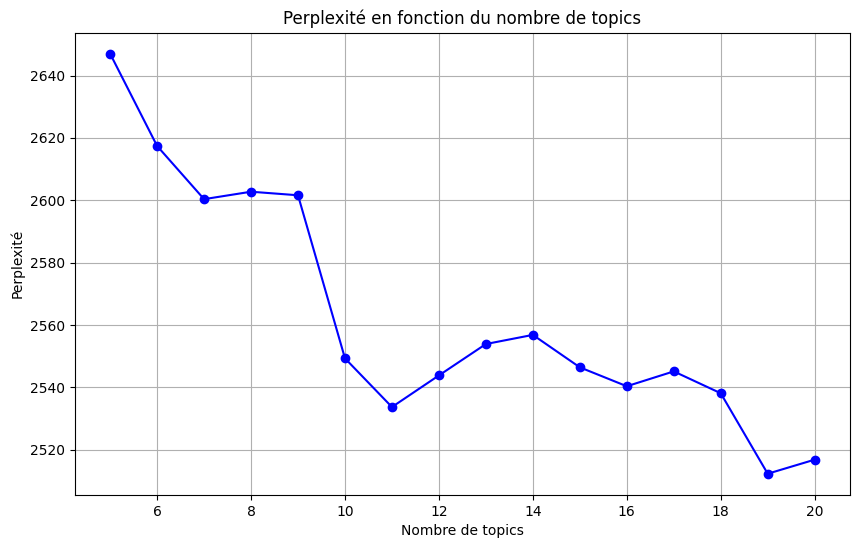

In [4]:

# Vectorisation du texte avec CountVectorizer (BoW)
vectorizer = CountVectorizer(max_df=0.95, min_df=2)  # Réduction des mots trop fréquents et trop rares
X_bow = vectorizer.fit_transform(df5['Cleaned_Title_Body'])  # Matrice BoW

# Séparer en train et test après vectorisation
X_train, X_test = train_test_split(X_bow, test_size=0.2, random_state=42)

perplexities = []

# Tester entre 5 et 20 topics
for n_topics in range(5, 21):
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10, n_jobs=-1)
    
    # Entraîner le modèle sur X_train
    lda.fit(X_train)  
    
    # Calcul de la perplexité sur X_test
    perplexity = lda.perplexity(X_test)
    perplexities.append((n_topics, perplexity))
    print(f"Perplexité pour {n_topics} topics : {perplexity}")

# Extraire les nombres de topics et leurs perplexités
n_topics_values, perplexity_values = zip(*perplexities)

# Tracer un graphe de la perplexité en fonction du nombre de topics
plt.figure(figsize=(10, 6))
plt.plot(n_topics_values, perplexity_values, marker='o', linestyle='-', color='b')
plt.title("Perplexité en fonction du nombre de topics")
plt.xlabel("Nombre de topics")
plt.ylabel("Perplexité")
plt.grid(True)
plt.show()


On peut raisonnablement penser que 19-20 topics sont intéressants à tester, mais attention, la perplexité seule ne suffit pas à expliquer la quallité des modèles.

**Cohérence Score**

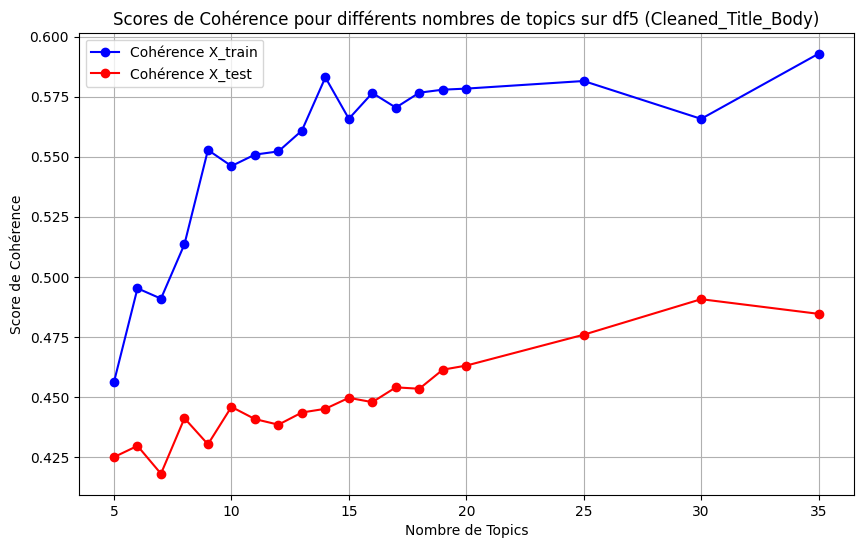

In [5]:

# Séparer df5 en X_train et X_test (par exemple 80% - 20%)
X_train, X_test = train_test_split(df5['Cleaned_Title_Body'], test_size=0.2, random_state=42)

# Tokenisation du texte brut pour X_train et X_test
train_tokens = [doc.split() for doc in X_train]  # Séparer le texte en mots
test_tokens = [doc.split() for doc in X_test]  # Séparer le texte en mots

# Créer un dictionnaire pour gensim (utilisé pour la cohérence)
train_dict = Dictionary(train_tokens)
test_dict = Dictionary(test_tokens)

# Créer un corpus BoW pour Gensim
train_corpus = [train_dict.doc2bow(doc) for doc in train_tokens]
test_corpus = [test_dict.doc2bow(doc) for doc in test_tokens]

# Liste des nombres de topics à tester
topic_numbers = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35]

# Listes pour stocker les scores de cohérence
coherence_train = []
coherence_test = []

# Calculer la cohérence pour chaque nombre de topics
for n_topics in topic_numbers:
    # Entraîner le modèle LDA avec Gensim
    lda_gensim = LdaModel(corpus=train_corpus, id2word=train_dict, num_topics=n_topics, random_state=42)

    
    # Calculer la cohérence sur X_train
    coherence_train.append(CoherenceModel(model=lda_gensim, texts=train_tokens, dictionary=train_dict, coherence='c_v').get_coherence())
    
    # Calculer la cohérence sur X_test
    coherence_test.append(CoherenceModel(model=lda_gensim, texts=test_tokens, dictionary=test_dict, coherence='c_v').get_coherence())

# Tracer les scores de cohérence pour X_train et X_test
plt.figure(figsize=(10, 6))
plt.plot(topic_numbers, coherence_train, marker='o', linestyle='-', color='b', label='Cohérence X_train')
plt.plot(topic_numbers, coherence_test, marker='o', linestyle='-', color='r', label='Cohérence X_test')

plt.title('Scores de Cohérence pour différents nombres de topics sur df5 (Cleaned_Title_Body)')
plt.xlabel('Nombre de Topics')
plt.ylabel('Score de Cohérence')
plt.legend()
plt.grid(True)
plt.show()


**Sur X_train** : La cohérence augmente progressivement et atteint un plateau à partir de 14 topics autour de 0.575. Cela indique qu’au-delà de ce nombre, les nouveaux topics n’apportent pas forcément une meilleure structuration de l’information dans les données d’entraînement.<br>
**Sur X_test** : La cohérence suit une croissance quasi-linéaire, démarrant à 0.425 (5 topics) et atteignant environ 0.48 (30 topics). Cela montre que le modèle généralise moins bien sur les données de test et qu’il y a probablement un peu d’overfitting sur l’entraînement.<br>
Un bon compromis serait autour de 14-20 topics, puisque c’est là que le plateau commence sur train, mais où le test continue encore légèrement de croître.<br>
On va tester py-Davis pour 15 et 20 topics.

**Py-Davis**

In [6]:

# Séparation des données en train et test (df5)
X_train, X_test = train_test_split(df5, test_size=0.2, random_state=42)

# Tokenisation de df5 pour X_train et X_test
X_train_tokens = [text.split() for text in X_train['Cleaned_Title_Body']]
X_test_tokens = [text.split() for text in X_test['Cleaned_Title_Body']]

# Création du dictionnaire et corpus BoW
dictionary = Dictionary(X_train_tokens)
corpus_train = [dictionary.doc2bow(text) for text in X_train_tokens]

# Entraînement du modèle LDA sur X_train uniquement
n_topics = 15
lda_model = LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=n_topics, passes=10, random_state=42)

# Génération de la visualisation avec pyLDAvis (seulement pour X_train)
vis = gensimvis.prepare(lda_model, corpus_train, dictionary)
pyLDAvis.display(vis)


In [7]:

# Entraînement du modèle LDA avec 20 topics

n_topics = 20
lda_model = LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=n_topics, passes=10, random_state=42)

# Génération de la visualisation avec pyLDAvis (seulement pour X_train)
vis = gensimvis.prepare(lda_model, corpus_train, dictionary)
pyLDAvis.display(vis)

20 Topics montrent une séparation beaucoup plus nette.

**LDA**

In [8]:
from sklearn.model_selection import train_test_split

# Séparer les données en train et test (80% - 20%)
X_train, X_test = train_test_split(df6, test_size=0.2, random_state=42)

# Initialiser LDA avec 20 topics
n_topics = 20
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# Entraîner LDA sur X_train
lda.fit(X_train)

# Appliquer LDA sur X_test pour obtenir la distribution des topics
topics_lda = lda.transform(X_test)

# Afficher les 10 mots les plus importants par topic
feature_names = np.array(df6.columns)  # Utiliser les mots comme noms de features

# Affichage des mots par topic
for topic_lda, topic in enumerate(lda.components_):
    top_words_lda = topic.argsort()[-10:][::-1]  # Indices des 10 mots les plus importants
    top_words = feature_names[top_words_lda]  # Récupérer les mots associés aux indices
    
    print(f"Topic {topic_lda + 1}:")  # Affichage avec numéro de topic (1-indexé)
    print(" ".join(top_words))  # Affichage des 10 mots dominants


Topic 1:
file python package install lib error py version run build
Topic 2:
js import angular module react ts app component config src
Topic 3:
int char printf array uint byte return float include bit
Topic 4:
np model import image plot array matrix shape numpy datum
Topic 5:
public string class new var private service net builder use
Topic 6:
const react import component div classname state child export route
Topic 7:
val view fun text var screen button compose item tab
Topic 8:
java org spring boot springframework dependency version apache class xml
Topic 9:
df column dataframe date row datum value pd panda year
Topic 10:
docker run server app port container host connect php connection
Topic 11:
android app flutter gradle com build device native ios version
Topic 12:
product form div field input value button label class item
Topic 13:
std int foo type template class function struct const void
Topic 14:
token user request api auth login app access use client
Topic 15:
node npm err re

In [9]:
# Liste pour stocker les mots dominants pour chaque topic
lda_topics = []

# Affichage des mots par topic et ajout dans la liste
for topic_lda, topic in enumerate(lda.components_):
    top_words_lda = topic.argsort()[-10:][::-1]  # Indices des 10 mots les plus importants
    top_words = feature_names[top_words_lda]  # Je récupére les mots associés aux indices
    
    lda_topics.append(" ".join(top_words))  # Ajouter les mots dominants pour chaque topic dans la liste

# Créer un DataFrame avec les topics
df_lda_topics = pd.DataFrame(lda_topics, columns=["LDA_topics"])

# Afficher le DataFrame des topics
print(df_lda_topics)


                                           LDA_topics
0   file python package install lib error py versi...
1   js import angular module react ts app componen...
2   int char printf array uint byte return float i...
3   np model import image plot array matrix shape ...
4   public string class new var private service ne...
5   const react import component div classname sta...
6   val view fun text var screen button compose it...
7   java org spring boot springframework dependenc...
8   df column dataframe date row datum value pd pa...
9   docker run server app port container host conn...
10  android app flutter gradle com build device na...
11  product form div field input value button labe...
12  std int foo type template class function struc...
13  token user request api auth login app access u...
14  node npm err report internal js ms visual erro...
15  div color px width text image style height cla...
16  self model def import py django print class re...
17  table query column value

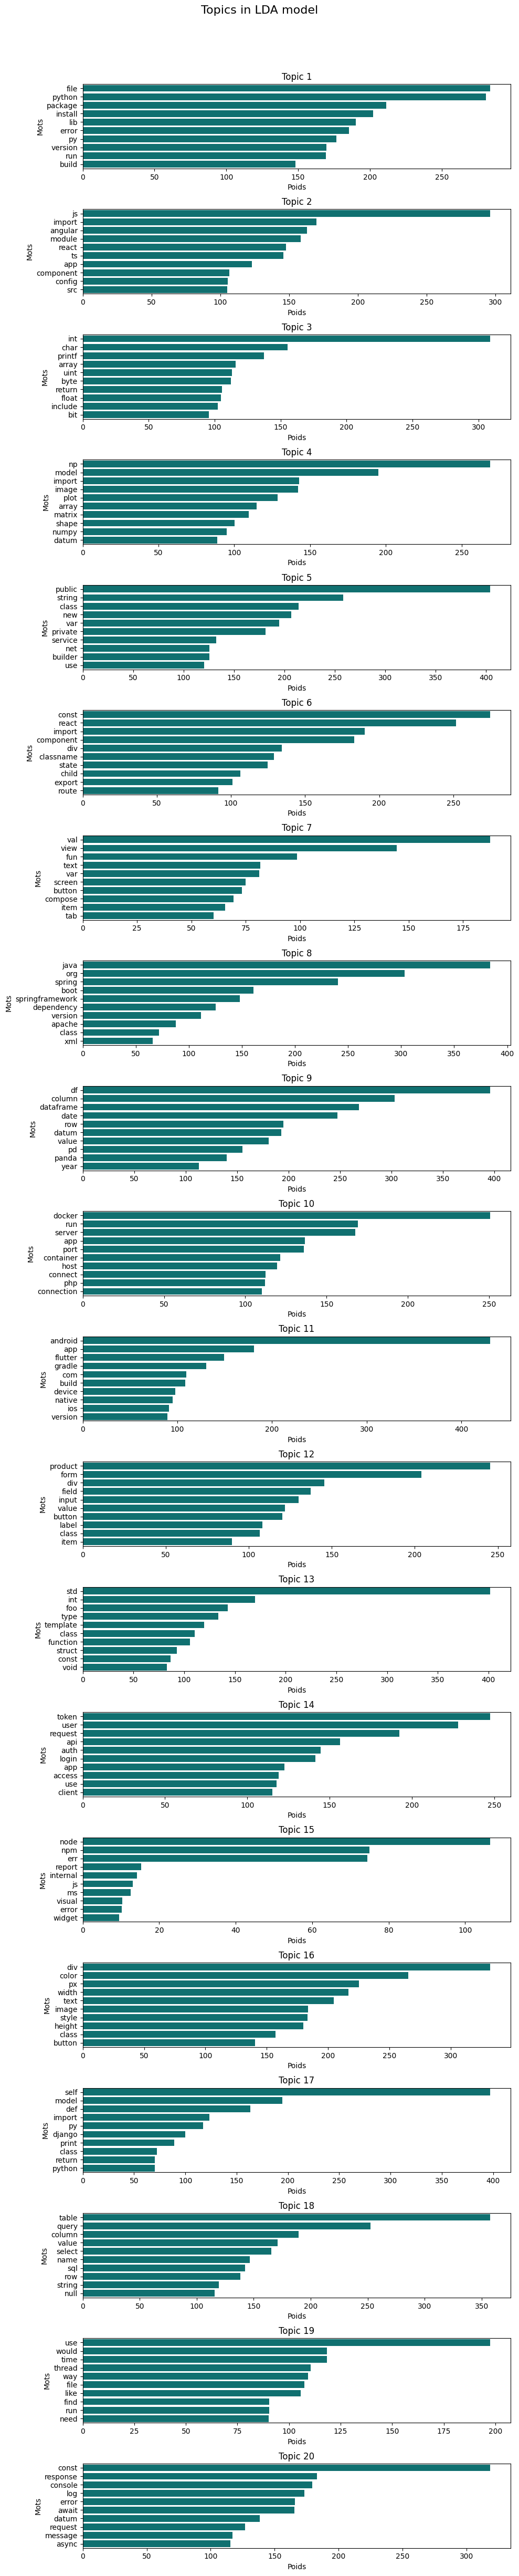

In [10]:

# Fonction pour afficher les top mots de tous les topics dans une seule figure
def plot_top_words(lda, feature_names, n_top_words=10, title='Topics in LDA model'):
    # Créer une figure pour afficher plusieurs subplots
    plt.figure(figsize=(10, 50))  # Taille de la figure ajustée pour afficher les 17 topics
    
    # Nombre de topics
    n_topics = len(lda.components_)
    
    # Créer un sous-graphe pour chaque topic
    for topic_lda, topic in enumerate(lda.components_):
        # Obtenons les indices des mots les plus significatifs pour ce topic
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_values = topic[top_indices]
        
        # Ajouter un subplot pour chaque topic
        plt.subplot(n_topics, 1, topic_lda + 1)
        sns.barplot(x=top_values, y=top_words, color='teal')  # Utilisation de 'color' au lieu de 'palette'
        plt.title(f"Topic {topic_lda + 1}")
        plt.xlabel('Poids')
        plt.ylabel('Mots')
    
    # Affichage du titre général
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Ajuste pour ne pas couper le titre
    plt.show()

# Appeler la fonction pour afficher les barplots
plot_top_words(lda, feature_names, n_top_words=10, title='Topics in LDA model')


**Liste des Topics LDA, sujets :**<br>
Topic 1 : Discussion liée à l'installation des packages **Python**, aux erreurs rencontrées.<br>
Topic 2 : Discussion sur l'utilisation de **JavaScript**, notamment l'importation des modules **Angular** et **React** dans une application **TypeScript**.<br>
Topic 3 : Evoque le langage C, y compris la manipulation des tableaux, la gestion des bits, des entiers, et des fonctionnalités comme printf et return.<br>
Topic 4 : Discussion sur l'utilisation de **Numpy**/**np** en Python.<br>
Topic 5 : Suggère la programmation orientée objet en C# ou Java, dans un environnement **.NET**.<br>
Topic 6 : Discussion sur l'utilisation de **React**, avec un focus sur l'importation des composants, le routage.<br>
Topic 7 : Suggère les fonctionnalités autour de l'interface utilisateur.<br>
Topic 8 : Discussion sur l’utilisation de **Java Spring**, en particulier avec Spring Boot, ainsi que les configurations de XML.<br>
Topic 9 : Discussion sur la gestion de DataFrames dans **Pandas**.<br>
Topic 10 : Discussion sur l'utilisation de **Docker** pour déployer une application, la gestion des ports et des connex° **PHP**, ainsi que la gestion des **serveurs**.<br>
Topic 11 : Discussion sur les applications **Android** avec **Flutter**, l'utilisation de **Gradle**, et la gestion des appareils et versions **iOS** (applications mobiles).<br>
Topic 12 : Evoque la création de formulaires web.<br>
Topic 13 : Evoque la programmation en C++, l’utilisation des fonctions, des structures ...<br>
Topic 14 : Discussion sur l’utilisation des **API**, la gestion de l'authentification via tokens.<br>
Topic 15 : Discussion autour des erreurs rencontrées dans **Node**.js, la gestion des erreurs **npm** et des problèmes internes, avec un focus sur les widgets.<br>
Topic 16 : Evoque la création d’interfaces utilisateur avec des divs, des couleurs, des taille d'images, et des styles CSS.<br>
Topic 17 : Discussion autour de la programmation en **Python** avec **Django**.<br>
Topic 18 : Discussion sur l'interrogation des bases de données via des requêtes **SQL**.<br>
Topic 19 : Discussion générale sur l'exécution de fichiers, la gestion des **threads** pour la performance.<br>
Topic 20 : Gestion des réponses API, la gestion des logs, des erreurs, et l'utilisation de l'**asynchrone** pour les requêtes réseau.



## 2.2. NMF

C:\Users\ggenv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ggenv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\ggenv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


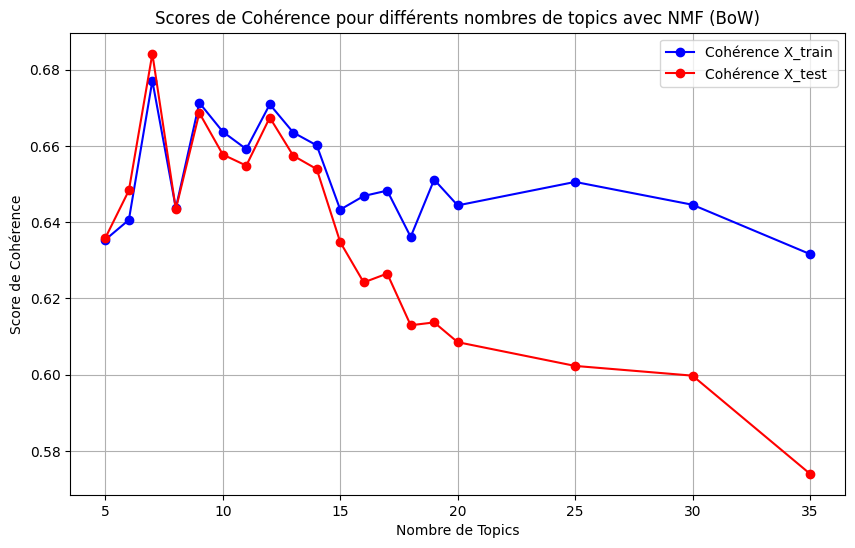

In [11]:

# Séparer df5 en X_train et X_test (80% - 20%)
X_train, X_test = train_test_split(df5['Cleaned_Title_Body'], test_size=0.2, random_state=42)

# Tokenisation des textes
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

# Création des dictionnaires Gensim
train_dict = Dictionary(X_train_tokens)
test_dict = Dictionary(X_test_tokens)

# Vectorisation avec CountVectorizer (BoW)
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), max_features=5000)  # Limite à 5000 mots les plus fréquents
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Liste des nombres de topics à tester
topic_numbers = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35]

# Listes pour stocker les scores de cohérence
coherence_train = []
coherence_test = []

# Calculer la cohérence pour chaque nombre de topics
for n_topics in topic_numbers:
    nmf_model = NMF(n_components=n_topics, random_state=42)
    nmf_model.fit(X_train_bow)  # Entraînement sur BoW et non TF-IDF

    # Extraction des mots les plus importants pour chaque topic
    feature_names = vectorizer.get_feature_names_out()
    topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]

    # Calcul de la cohérence sur X_train
    coherence_train.append(CoherenceModel(topics=topics, texts=X_train_tokens, dictionary=train_dict, coherence='c_v').get_coherence())

    # Calcul de la cohérence sur X_test
    coherence_test.append(CoherenceModel(topics=topics, texts=X_test_tokens, dictionary=test_dict, coherence='c_v').get_coherence())

# Tracer les scores de cohérence pour X_train et X_test
plt.figure(figsize=(10, 6))
plt.plot(topic_numbers, coherence_train, marker='o', linestyle='-', color='b', label='Cohérence X_train')
plt.plot(topic_numbers, coherence_test, marker='o', linestyle='-', color='r', label='Cohérence X_test')

plt.title('Scores de Cohérence pour différents nombres de topics avec NMF (BoW)')
plt.xlabel('Nombre de Topics')
plt.ylabel('Score de Cohérence')
plt.legend()
plt.grid(True)
plt.show()


**Py-Davis**

In [12]:

# Création de vectorizer et transformation des données
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df5["Cleaned_Title_Body"]) 

# Séparation train/test
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Appliquer NMF
n_topics = 12
nmf_model = NMF(n_components=n_topics, random_state=42)
W_train = nmf_model.fit_transform(X_train)
H_train = nmf_model.components_

# Normalisation des distributions des termes
topic_term_dists = H_train / H_train.sum(axis=1)[:, np.newaxis]  # Normalisation des distributions de mots
doc_topic_dists = W_train / W_train.sum(axis=1)[:, np.newaxis]   # Normalisation des distributions de documents (optionnelle)

# Longueur des documents
doc_lengths = np.asarray(X_train.sum(axis=1)).flatten()  

# Récupérer les termes du vocabulaire du vectorizer utilisé
vocab = vectorizer.get_feature_names_out()  

# Fréquence des termes
term_freqs = np.asarray(X_train.sum(axis=0)).flatten()  

# Vérification de la longueur des variables
print(len(vocab))
print(len(term_freqs))

# Construire l’objet PyLDAvis
vis_nmf = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_freqs)

# Afficher la visualisation
pyLDAvis.display(vis_nmf)

244741
244741


C:\Users\ggenv\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\ggenv\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\ggenv\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [13]:

# Nombre de top termes à afficher pour chaque topic
n_top_terms = 10

# Normalisation des distributions des termes (pour récupérer les top mots)
topic_term_dists = H_train / H_train.sum(axis=1)[:, np.newaxis]  # Normalisation des distributions de mots

# Récupérer les indices des top termes pour chaque topic
top_terms_indices = np.argsort(topic_term_dists, axis=1)[:, ::-1]  # Tri des termes par ordre décroissant

# Créer un dictionnaire pour stocker les résultats
topics_terms = {}

# Extraction des termes les plus importants pour chaque topic
for topic_idx, term_indices in enumerate(top_terms_indices):
    top_terms = [vocab[i] for i in term_indices[:n_top_terms]]  # Récupérer les termes les plus significatifs
    topics_terms[f"Topic {topic_idx + 1}"] = top_terms  # Stocker les termes pour chaque topic

# Affichage des résultats sous forme de liste pour chaque topic dans l'ordre des topics
for topic, terms in topics_terms.items():
    print(f"{topic}: {', '.join(terms)}")


Topic 1: array, int, function, use, number, value, time, np, code, would
Topic 2: string, public, name, class, product, value, field, type, table, key
Topic 3: div, px, class, button, text, style, color, width, image, classname
Topic 4: java, org, spring, artifactid, groupid, springframework, boot, dependency, version, jar
Topic 5: user, request, const, token, response, api, log, error, email, await
Topic 6: std, int, include, template, cout, const, vector, auto, typename, char
Topic 7: self, model, def, import, py, torch, django, class, print, none
Topic 8: react, js, import, component, const, native, app, node, export, ts
Topic 9: android, gradle, app, flutter, com, google, androidx, permission, intent, build
Topic 10: df, column, dataframe, row, date, pd, value, table, datum, panda
Topic 11: file, python, py, package, line, lib, error, site, install, pip
Topic 12: app, azure, service, docker, run, server, net, build, use, microsoft


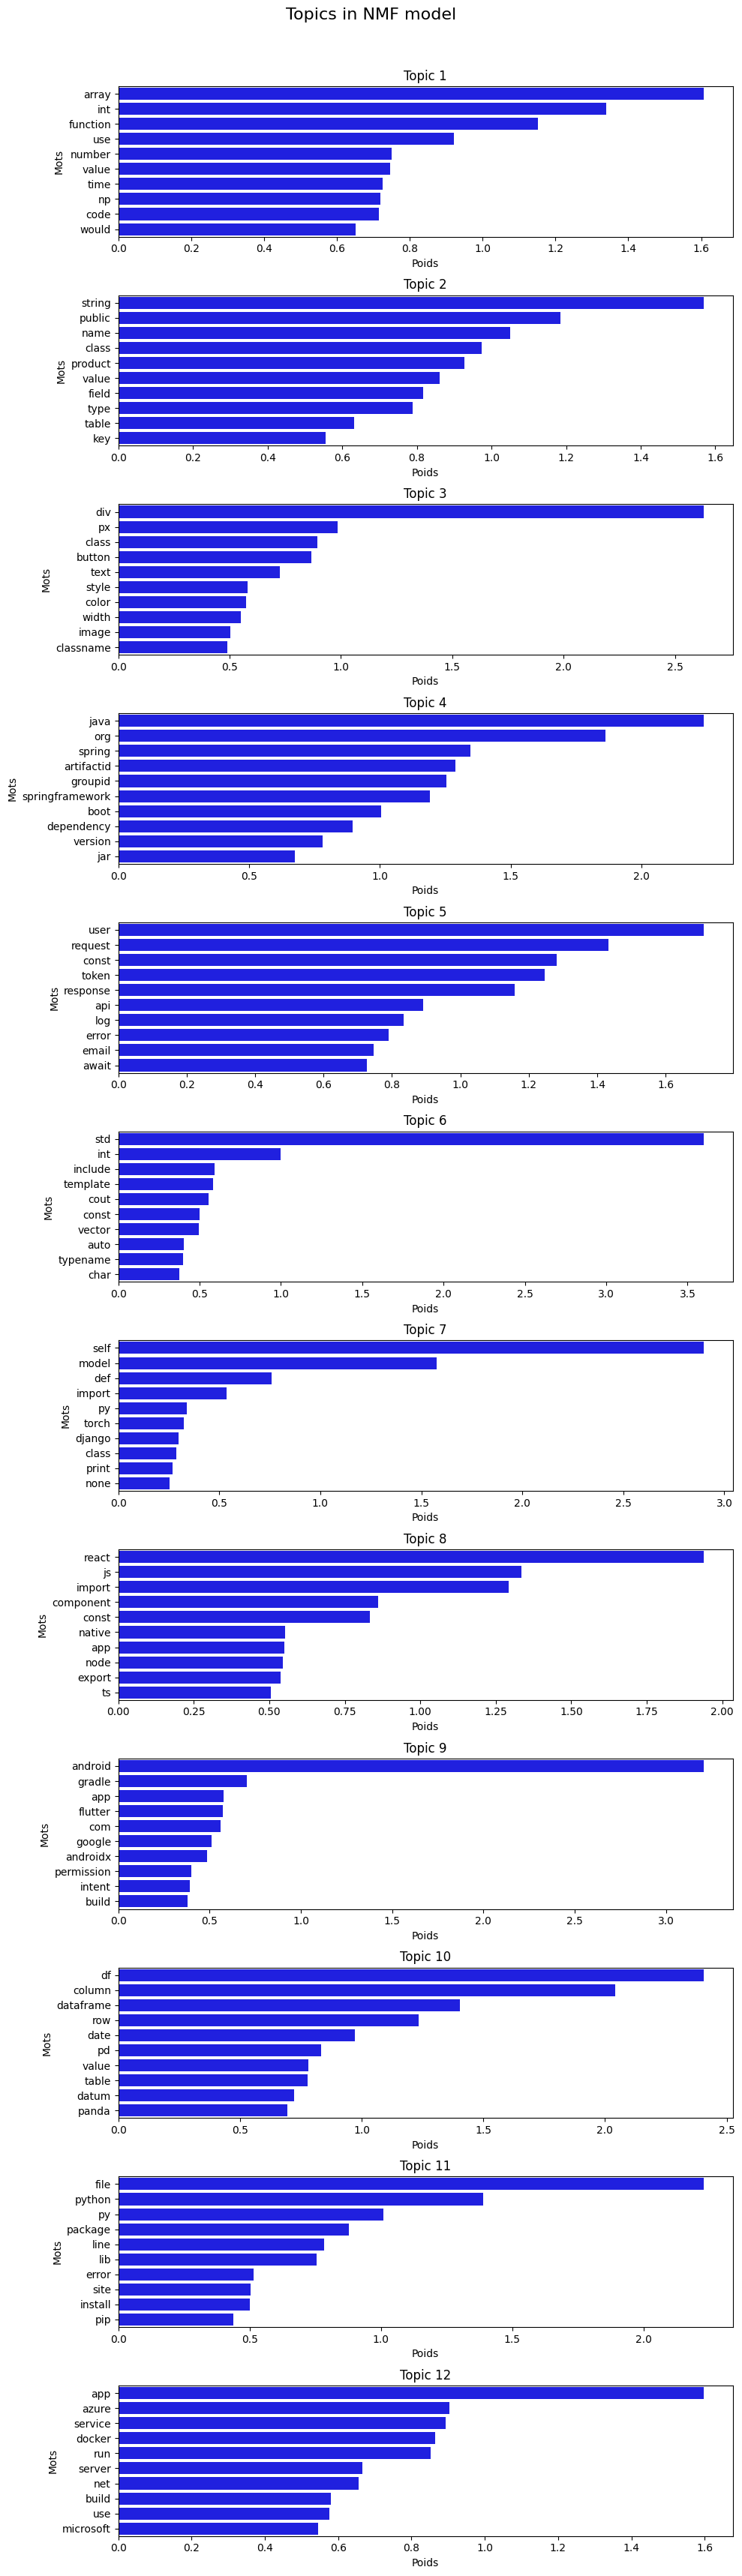

In [14]:

# Fonction pour afficher les top mots de tous les topics dans une seule figure
def plot_top_words_nmf(nmf_model, feature_names, n_top_words=10, title='Topics in NMF model'):
    # Créer une figure pour afficher plusieurs subplots
    plt.figure(figsize=(10, 35))  # Taille de la figure
    
    # Nombre de topics
    n_topics = nmf_model.components_.shape[0]
    
    # Créer un sous-graphe pour chaque topic
    for topic_idx, topic in enumerate(nmf_model.components_):
        # Obtenons les indices des mots les plus significatifs pour ce topic
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_values = topic[top_indices]
        
        # Ajouter un subplot pour chaque topic
        plt.subplot(n_topics, 1, topic_idx + 1)
        sns.barplot(x=top_values, y=top_words, color='blue')
        plt.title(f"Topic {topic_idx + 1}")
        plt.xlabel('Poids')
        plt.ylabel('Mots')
    
    # Affichage du titre général
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Ajustement
    plt.show()

# Appeler la fonction pour afficher les barplots
plot_top_words_nmf(nmf_model, vectorizer.get_feature_names_out(), n_top_words=10, title='Topics in NMF model')


Topic 1 : Des termes liés aux types de données numériques et à la programmation avec des fonctions **numpy** en Python.<br>
Topic 2 : Suggère la gestion de bases de données, notamment les clés, les tables et les types de données.<br>
Topic 3 : Des éléments du CSS et du design d'interface utilisateur, comme la mise en forme, les boutons, les couleurs et les images.<br>
Topic 4 : Discussion sur la configuration et à l'utilisation de **Spring** Boot en **Java**.<br>
Topic 5 : Discussion sur la gestion des requêtes **API**, des réponses et des erreurs côté utilisateur.<br>
Topic 6 : Evoque C++ avec des types de données comme int, des templates et des structures comme vector.<br>
Topic 7 : Discussion sur **Python** et **PyTorch** pour la création et l'entraînement de modèles d'apprentissage automatique.<br>
Topic 8 : Discussion sur **React**, **JavaScript**, les composants, et le développement d'applications web.<br>
Topic 9 : Discussion sur **Android** et **Flutter**, y compris la configuration et les permissions.<br>
Topic 10 : Discussion sur **Pandas**, en Python, avec des DataFrames et des colonnes.<br>
Topic 11 : Discussion sur **Python**, de ses bibliothèques et à la gestion des erreurs d'installation.<br>
Topic 12 : Discussion sur le déploiement d'applications sur **Azure**, avec **Docker** et les services serveur.<br>

## Métriques post-modélisation

**Jaccard sur LDA**

In [15]:
from sklearn.metrics import jaccard_score

# Convertir les topics du DataFrame en ensembles de mots
lda_topic_sets = [set(topic.split()) for topic in df_lda_topics["LDA_topics"]]

# Calculer Jaccard pour chaque paire de topics
jaccard_scores = []

# Comparer chaque topic avec lui-même ou avec les autres
for i in range(len(lda_topic_sets)):
    for j in range(i + 1, len(lda_topic_sets)):
        # Union des mots pour vectorisation
        all_words = list(lda_topic_sets[i].union(lda_topic_sets[j]))
        
        # Transformer en vecteurs binaires
        lda_vector_i = [1 if word in lda_topic_sets[i] else 0 for word in all_words]
        lda_vector_j = [1 if word in lda_topic_sets[j] else 0 for word in all_words]
        
        # Calculer Jaccard
        jaccard_sim = jaccard_score(lda_vector_i, lda_vector_j)
        jaccard_scores.append((i, j, jaccard_sim))  # Ajouter l'indice des topics et le score

# Afficher les scores de Jaccard
for i, j, score in jaccard_scores:  # Décomposer correctement le tuple
    print(f"Jaccard Score entre Topic {i + 1} et Topic {j + 1}: {score}")
    
# Afficher la moyenne des scores
mean_jaccard_lda = np.mean([score for _, _, score in jaccard_scores])
print(f"Moyenne des Scores Jaccard entre les Topics LDA : {mean_jaccard_lda}")


Jaccard Score entre Topic 1 et Topic 2: 0.0
Jaccard Score entre Topic 1 et Topic 3: 0.0
Jaccard Score entre Topic 1 et Topic 4: 0.0
Jaccard Score entre Topic 1 et Topic 5: 0.0
Jaccard Score entre Topic 1 et Topic 6: 0.0
Jaccard Score entre Topic 1 et Topic 7: 0.0
Jaccard Score entre Topic 1 et Topic 8: 0.05263157894736842
Jaccard Score entre Topic 1 et Topic 9: 0.0
Jaccard Score entre Topic 1 et Topic 10: 0.05263157894736842
Jaccard Score entre Topic 1 et Topic 11: 0.1111111111111111
Jaccard Score entre Topic 1 et Topic 12: 0.0
Jaccard Score entre Topic 1 et Topic 13: 0.0
Jaccard Score entre Topic 1 et Topic 14: 0.0
Jaccard Score entre Topic 1 et Topic 15: 0.05263157894736842
Jaccard Score entre Topic 1 et Topic 16: 0.0
Jaccard Score entre Topic 1 et Topic 17: 0.1111111111111111
Jaccard Score entre Topic 1 et Topic 18: 0.0
Jaccard Score entre Topic 1 et Topic 19: 0.1111111111111111
Jaccard Score entre Topic 1 et Topic 20: 0.05263157894736842
Jaccard Score entre Topic 2 et Topic 3: 0.0


Les Topics sont bien séparés pour LDA (Jaccard 0.0207)

**Kulback Leiber sur LDA**

In [16]:
from sklearn.metrics import pairwise_distances
from scipy.special import kl_div

# Obtenir les distributions des topics de LDA (les matrices de composantes)
lda_topic_distributions = lda.components_

# Normaliser les composantes pour obtenir des probabilités
lda_topic_distributions /= lda_topic_distributions.sum(axis=1)[:, np.newaxis]

# Calculer la divergence de Kullback-Leibler entre chaque paire de topics
kl_scores = []

for i in range(len(lda_topic_distributions)):
    for j in range(i + 1, len(lda_topic_distributions)):
        # Divergence KL entre le topic i et le topic j
        kl_score = np.sum(kl_div(lda_topic_distributions[i], lda_topic_distributions[j]))
        kl_scores.append((i, j, kl_score))

# Afficher les résultats
for i, j, score in kl_scores:
    print(f"Divergence KL entre Topic {i + 1} et Topic {j + 1}: {score}")
    
# Afficher la moyenne des scores
mean_kl = np.mean([score for _, _, score in kl_scores])
print(f"Moyenne des Scores de Divergence KL entre les Topics LDA : {mean_kl}")


Divergence KL entre Topic 1 et Topic 2: 0.9595316648483276
Divergence KL entre Topic 1 et Topic 3: 1.3779494762420654
Divergence KL entre Topic 1 et Topic 4: 1.3793790340423584
Divergence KL entre Topic 1 et Topic 5: 1.5033588409423828
Divergence KL entre Topic 1 et Topic 6: 1.9064592123031616
Divergence KL entre Topic 1 et Topic 7: 1.9513335227966309
Divergence KL entre Topic 1 et Topic 8: 1.4292736053466797
Divergence KL entre Topic 1 et Topic 9: 1.9984098672866821
Divergence KL entre Topic 1 et Topic 10: 0.6124285459518433
Divergence KL entre Topic 1 et Topic 11: 0.7990067005157471
Divergence KL entre Topic 1 et Topic 12: 1.9699108600616455
Divergence KL entre Topic 1 et Topic 13: 1.766129970550537
Divergence KL entre Topic 1 et Topic 14: 1.2664377689361572
Divergence KL entre Topic 1 et Topic 15: 1.6984124183654785
Divergence KL entre Topic 1 et Topic 16: 1.731745719909668
Divergence KL entre Topic 1 et Topic 17: 1.0195584297180176
Divergence KL entre Topic 1 et Topic 18: 1.6788496

La divergence est modérée pour LDA (KL 1.691)

**Jaccard pour NMF**

In [17]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.model_selection import train_test_split

# Séparer df5 en X_train et X_test (80% - 20%)
X_train, X_test = train_test_split(df5['Cleaned_Title_Body'], test_size=0.2, random_state=42)

# Tokenisation des textes
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

# Création du CountVectorizer et vectorisation
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Liste des nombres de topics à tester
topic_numbers = [12]

# Initialiser les dictionnaires pour Gensim
train_dict = Dictionary(X_train_tokens)
test_dict = Dictionary(X_test_tokens)

# Calculer les topics avec NMF et la similarité de Jaccard sur X_test
jaccard_similarities = []

for n_topics in topic_numbers:
    # Initialiser et entraîner le modèle NMF
    nmf_model = NMF(n_components=n_topics, random_state=42)
    nmf_model.fit(X_train_bow)  # Entraînement sur X_train_bow

    # Extraction des mots dominants pour chaque topic
    feature_names = vectorizer.get_feature_names_out()
    topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]

    # Appliquer NMF sur X_test pour obtenir la distribution des topics
    topics_test = nmf_model.transform(X_test_bow)

    # Extraire les mots dominants pour chaque topic sur X_test
    nmf_topics_test = []
    for topic_nmf in range(n_topics):
        top_words_nmf = feature_names[nmf_model.components_[topic_nmf].argsort()[-10:]]  # 10 mots dominants
        nmf_topics_test.append(set(top_words_nmf))  # Ajouter l'ensemble de mots à la liste des topics NMF sur test

    # Calcul de la similarité de Jaccard pour chaque paire de topics sur X_test
    for i in range(n_topics):
        for j in range(i + 1, n_topics):
            intersection = nmf_topics_test[i].intersection(nmf_topics_test[j])  # Mots communs entre les 2 topics
            union = nmf_topics_test[i].union(nmf_topics_test[j])  # Union des mots des 2 topics
            jaccard_index = len(intersection) / len(union)  # Calcul de Jaccard
            jaccard_similarities.append((n_topics, i, j, jaccard_index))  # Sauvegarder le résultat

# Affichage des résultats de la similarité de Jaccard pour les pairs de topics sur X_test
for (n_topics, i, j, score) in jaccard_similarities:
    print(f"Jaccard Similarity between Topic {i+1} and Topic {j+1} (for {n_topics} topics): {score:.4f}")


C:\Users\ggenv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Jaccard Similarity between Topic 1 and Topic 2 (for 12 topics): 0.0000
Jaccard Similarity between Topic 1 and Topic 3 (for 12 topics): 0.0000
Jaccard Similarity between Topic 1 and Topic 4 (for 12 topics): 0.0000
Jaccard Similarity between Topic 1 and Topic 5 (for 12 topics): 0.0000
Jaccard Similarity between Topic 1 and Topic 6 (for 12 topics): 0.3333
Jaccard Similarity between Topic 1 and Topic 7 (for 12 topics): 0.0000
Jaccard Similarity between Topic 1 and Topic 8 (for 12 topics): 0.0000
Jaccard Similarity between Topic 1 and Topic 9 (for 12 topics): 0.1765
Jaccard Similarity between Topic 1 and Topic 10 (for 12 topics): 0.0526
Jaccard Similarity between Topic 1 and Topic 11 (for 12 topics): 0.0000
Jaccard Similarity between Topic 1 and Topic 12 (for 12 topics): 0.0000
Jaccard Similarity between Topic 2 and Topic 3 (for 12 topics): 0.0000
Jaccard Similarity between Topic 2 and Topic 4 (for 12 topics): 0.0000
Jaccard Similarity between Topic 2 and Topic 5 (for 12 topics): 0.0000
Jac

In [18]:
# Calcul de la moyenne des scores de Jaccard
jaccard_scores = [score for (_, _, _, score) in jaccard_similarities]
mean_jaccard = np.mean(jaccard_scores)

print(f"Moyenne des scores de Jaccard : {mean_jaccard:.4f}")

Moyenne des scores de Jaccard : 0.0254


Les Topics NMF sont aussi bien distincts, 0.0254 pour NMF, contre 0.0207 pour LDA, donc très similaire.

**KL pour NMF**

In [20]:
from sklearn.preprocessing import normalize
from itertools import combinations

# Extraire les 10 termes les plus importants pour chaque topic
terms = df6.columns  # Les noms des colonnes de df6 sont les termes
H = nmf_model.components_  # Matrice des termes par topics

# Normaliser les composantes de H pour chaque topic (chaque ligne doit être une distribution de probabilité)
H_normalized = normalize(H, norm='l1', axis=1)

# Fonction pour calculer la divergence KL entre deux distributions
def kl_divergence(p, q):
    # Eviter la division par zéro ou les log(0)
    p = np.maximum(p, 1e-10)
    q = np.maximum(q, 1e-10)
    return np.sum(p * np.log(p / q))

# Calcul de la KL divergence entre chaque paire de topics
kl_scores_NMF = {}
for (topic1, topic2) in combinations(range(len(H_normalized)), 2):
    score = kl_divergence(H_normalized[topic1], H_normalized[topic2])
    kl_scores_NMF[f"Topic {topic1} vs Topic {topic2}"] = score

# Affichage des scores de KL pour NMF
for pair, score in kl_scores_NMF.items():
    print(f"{pair}: {score:.4f}")

# Calculer la moyenne des scores de KL pour NMF
average_kl_NMF = sum(kl_scores_NMF.values()) / len(kl_scores_NMF)

# Afficher la moyenne
print(f"Moyenne des scores de KL pour NMF: {average_kl_NMF:.4f}")


Topic 0 vs Topic 1: 9.8632
Topic 0 vs Topic 2: 12.9405
Topic 0 vs Topic 3: 16.4895
Topic 0 vs Topic 4: 14.8855
Topic 0 vs Topic 5: 5.7646
Topic 0 vs Topic 6: 11.0993
Topic 0 vs Topic 7: 13.4769
Topic 0 vs Topic 8: 8.7439
Topic 0 vs Topic 9: 13.4366
Topic 0 vs Topic 10: 11.3464
Topic 0 vs Topic 11: 14.4459
Topic 1 vs Topic 2: 6.6537
Topic 1 vs Topic 3: 11.2984
Topic 1 vs Topic 4: 9.6079
Topic 1 vs Topic 5: 8.9348
Topic 1 vs Topic 6: 6.8646
Topic 1 vs Topic 7: 8.8133
Topic 1 vs Topic 8: 7.7233
Topic 1 vs Topic 9: 9.6053
Topic 1 vs Topic 10: 6.6041
Topic 1 vs Topic 11: 7.3797
Topic 2 vs Topic 3: 12.8114
Topic 2 vs Topic 4: 10.1904
Topic 2 vs Topic 5: 11.2119
Topic 2 vs Topic 6: 8.0781
Topic 2 vs Topic 7: 7.6566
Topic 2 vs Topic 8: 12.0286
Topic 2 vs Topic 9: 13.2552
Topic 2 vs Topic 10: 9.3727
Topic 2 vs Topic 11: 10.3630
Topic 3 vs Topic 4: 14.8282
Topic 3 vs Topic 5: 17.7153
Topic 3 vs Topic 6: 15.5370
Topic 3 vs Topic 7: 13.5499
Topic 3 vs Topic 8: 16.9079
Topic 3 vs Topic 9: 14.3509
T

L'indice KL de divergence est bien meilleur pour NMF (9.0274) que pour celui de LDA (KL LDA 1.691).

CONCLUSION GÉNÉRALE: Pour la modélisation

NMF semble donc mieux structurer les topics pour ce jeu de données, en créant des clusters plus différenciés.